# UTS Machine Learning - Tugas Clustering
# Nama: M Faishal Abdurrahman
# NIM: 1103213015

Import Library

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

Mount Google Drive

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Dataset

In [19]:
path_clustering = '/content/drive/My Drive/UTS/UTSClustering.csv'
df_clustering = pd.read_csv(path_clustering, encoding='latin1')

EKSPLORASI DATA AWAL

In [20]:
print("Informasi Dataset:")
print(df_clustering.info())

print("\nStatistik Deskriptif:")
print(df_clustering.describe())

print("\nJumlah data missing:")
print(df_clustering.isnull().sum())

print("\nSampel Data:")
df_clustering.head()

# Identifikasi tipe data kolom
numerical_cols = df_clustering.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df_clustering.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nKolom Numerik ({len(numerical_cols)}): {numerical_cols}")
print(f"\nKolom Kategorikal ({len(categorical_cols)}): {categorical_cols}")

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Statistik Deskriptif:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.

VISUALISASI DATA

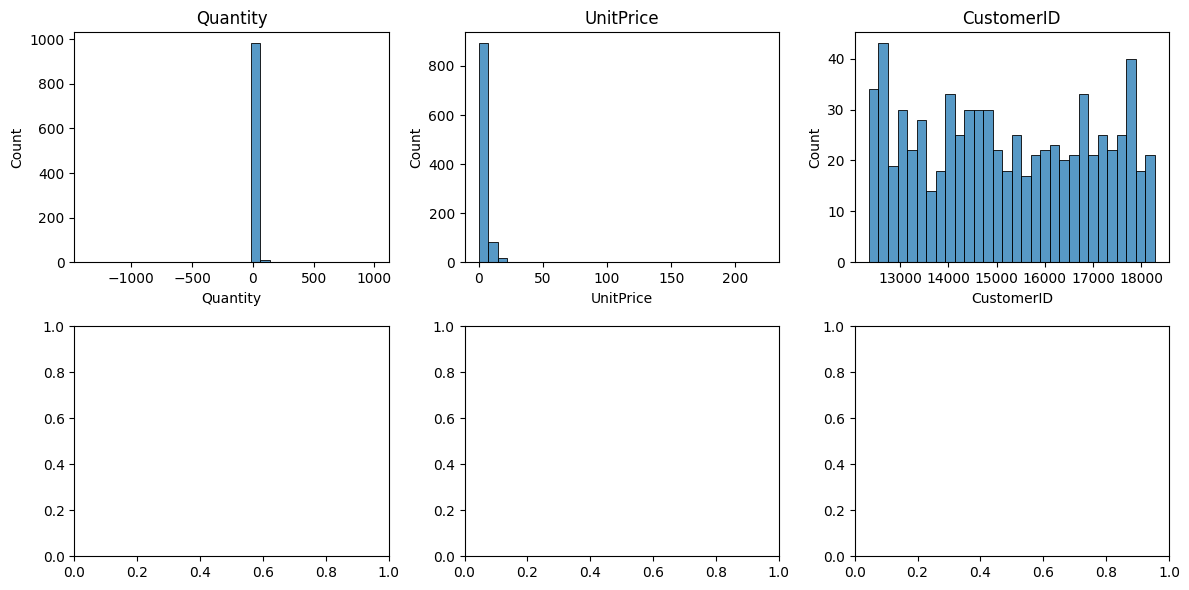

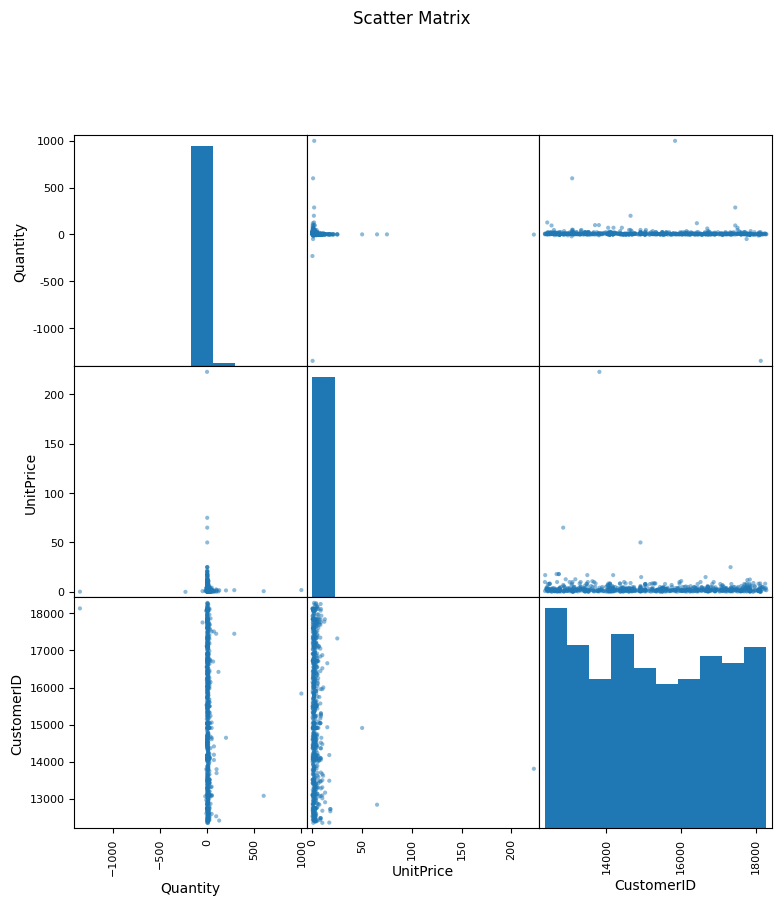

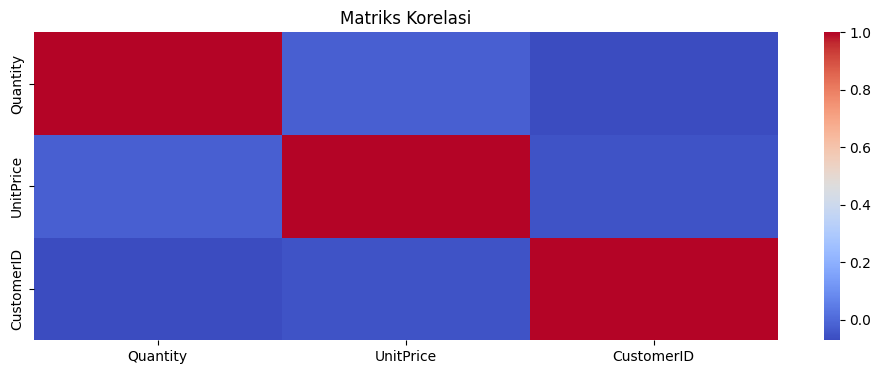

In [21]:
#  Berapa banyak fitur yang ingin diplot
n_plot = 6
sel_cols = numerical_cols[:n_plot]

# Sampling data
df_sample = df_clustering.sample(n= min(len(df_clustering), 1000), random_state=42)

# 3. Histogram
n_cols = 3
n_rows = math.ceil(n_plot / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
for ax, col in zip(axes.flatten(), sel_cols):
    sns.histplot(df_sample[col], kde=False, ax=ax, bins=30)
    ax.set_title(col)
# kosongkan sisa subplot jika ada
for ax in axes.flatten()[n_plot:]:
    ax.axis('off')
plt.tight_layout()
plt.show()

# 4. Scatter matrix (ambil 4 fitur pertama saja atau sesuai kebutuhan)
sm_cols = sel_cols[:4]
scatter_matrix(df_sample[sm_cols], diagonal='hist', alpha=0.5,
               figsize=(3*len(sm_cols), 3*len(sm_cols)))
plt.suptitle('Scatter Matrix', y=1.02)
plt.show()

# 5. Heatmap korelasi
plt.figure(figsize=(4*len(sel_cols), 4))
sns.heatmap(df_sample[sel_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Matriks Korelasi')
plt.show()

DATA PREPROCESSING


Bentuk data setelah preprocessing: (2000, 5779)
Variance explained by PCA components: [0.14888933 0.14480405]


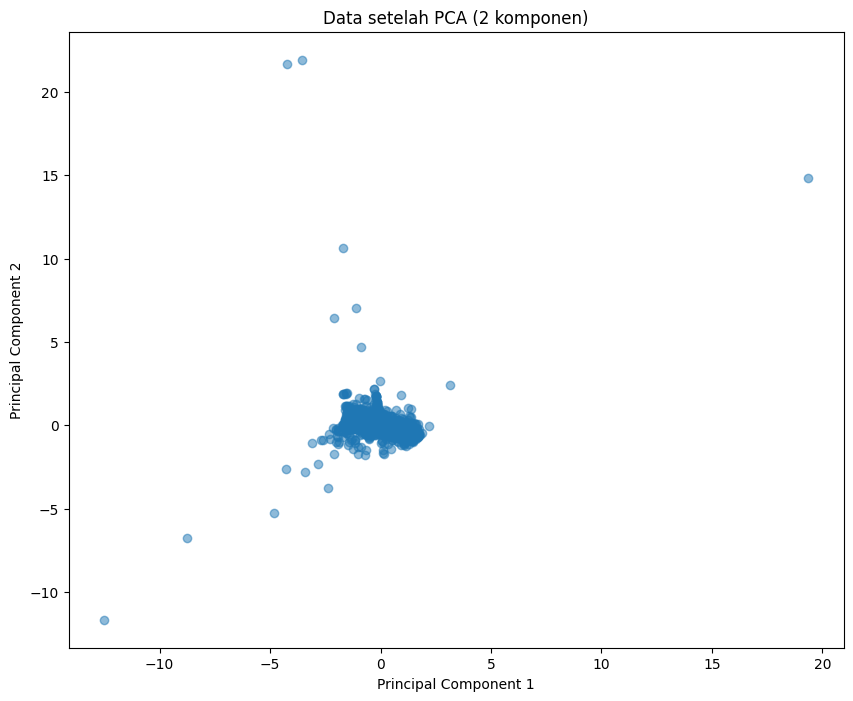

In [22]:
# Handling missing values
df_clean = df_clustering.copy()
max_samples = 2000
if len(df_clean) > max_samples:
    df_clean = df_clean.sample(max_samples, random_state=42)

# Ubah numerik ke float32
df_clean[numerical_cols] = df_clean[numerical_cols].astype('float32')

# Untuk kolom numerik, isi dengan median
for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
# Untuk kolom kategorikal, isi dengan mode
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Preprocessing Pipeline
# Buat preprocessor untuk kolom numerik dan kategorikal
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Gabungkan preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols) if categorical_cols else None
    ],
    remainder='drop'
)

# Terapkan preprocessing
X = preprocessor.fit_transform(df_clean)
print(f"\nBentuk data setelah preprocessing: {X.shape}")

# Dimensionality reduction dengan PCA untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(f"Variance explained by PCA components: {pca.explained_variance_ratio_}")

# Visualisasi data setelah PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('Data setelah PCA (2 komponen)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

CLUSTERING DENGAN KMEANS

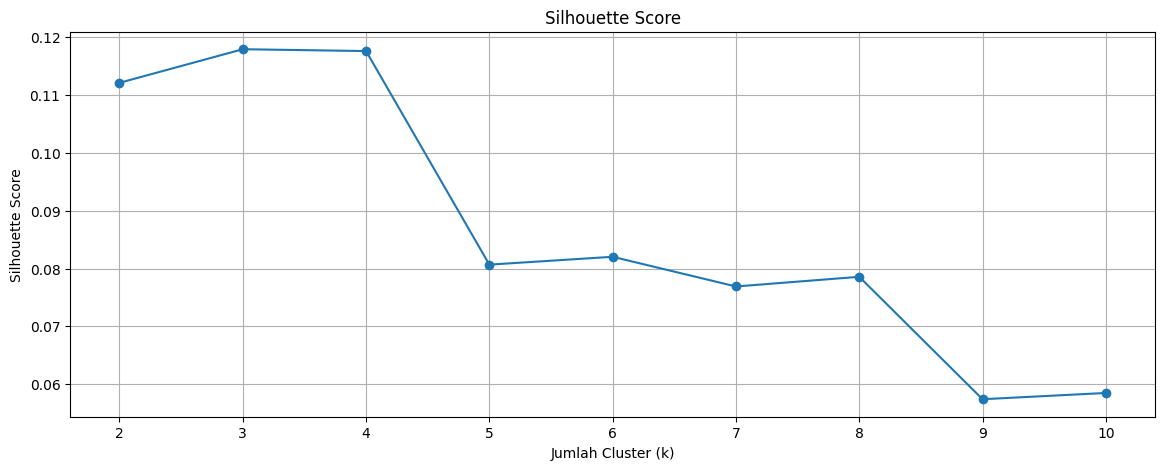

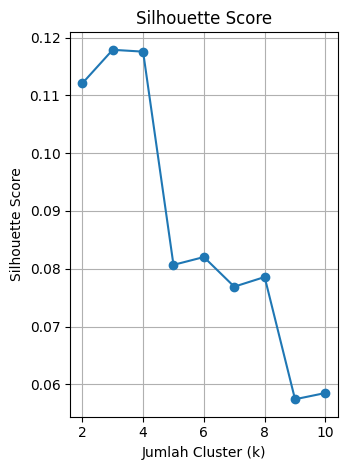


Evaluasi KMeans (k=3):
Silhouette Score: 0.1179
Davies-Bouldin Index: 1.7719


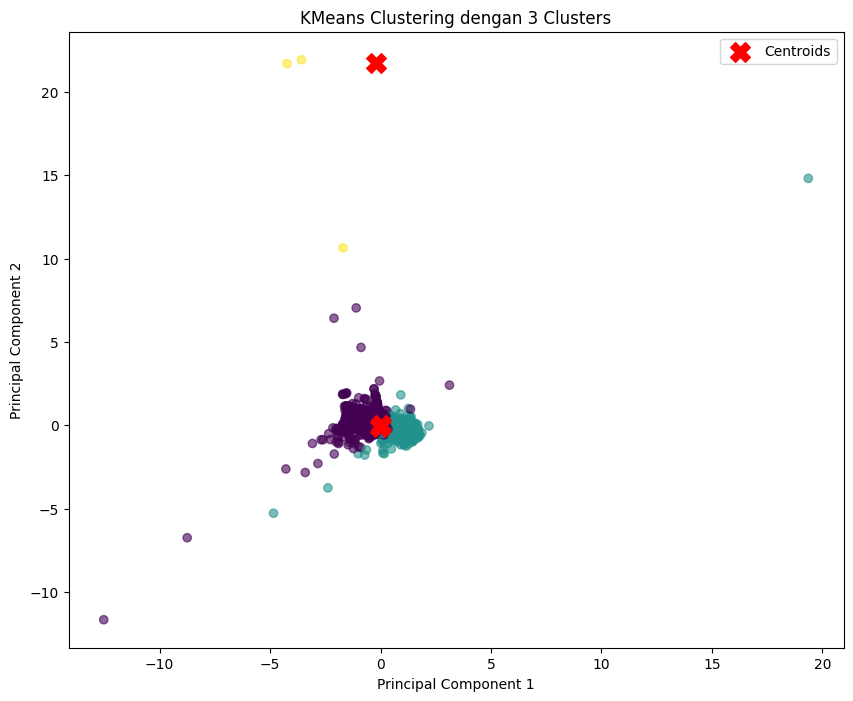

In [23]:
# Subsampling X untuk Elbow & Silhouette
max_samp = 2000
if X.shape[0] > max_samp:
    idx = np.random.choice(X.shape[0], size=max_samp, replace=False)
    X_samp = X[idx]
else:
    X_samp = X

# Menentukan jumlah cluster optimal dengan Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    if k > 1:  # Silhouette score memerlukan minimal 2 cluster
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(14, 5))

plt.plot(list(k_range), silhouette_scores, 'o-')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

plt.subplot(1, 2, 2)
plt.plot(list(k_range), silhouette_scores, 'o-')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Tentukan k optimal berdasarkan Elbow Method dan Silhouette
k_optimal = 3  # Ganti dengan nilai sesuai analisis grafik

# Fit KMeans dengan k optimal
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans.fit(X)
clusters_kmeans = kmeans.labels_

# Evaluasi model KMeans
silhouette_kmeans = silhouette_score(X, clusters_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(X, clusters_kmeans)
print(f"\nEvaluasi KMeans (k={k_optimal}):")
print(f"Silhouette Score: {silhouette_kmeans:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_kmeans:.4f}")

# Visualisasi hasil KMeans pada data yang telah di-PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='red', marker='X', s=200, label='Centroids')
plt.title(f'KMeans Clustering dengan {k_optimal} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

CLUSTERING DENGAN DBSCAN

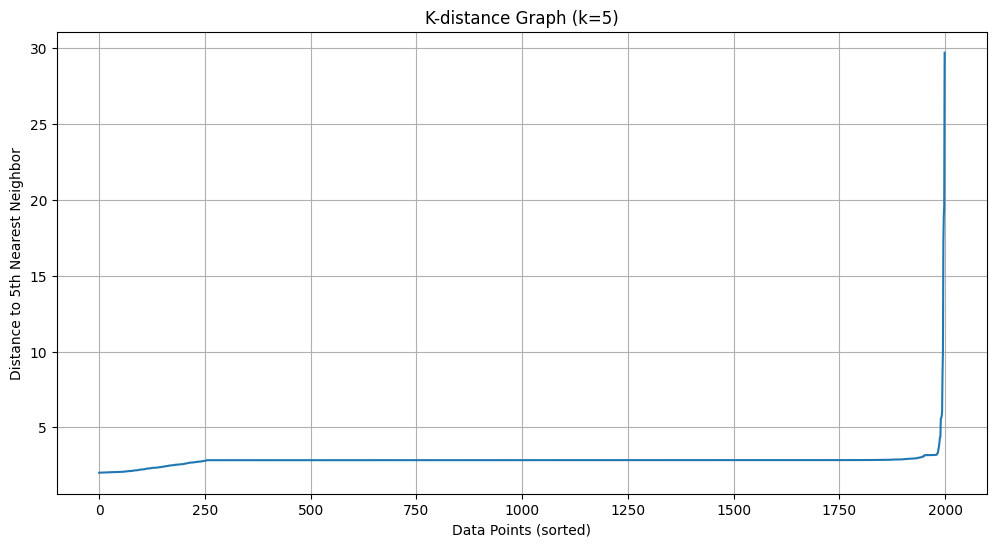


Evaluasi DBSCAN (eps=0.5, min_samples=5):
Jumlah Cluster: 0
Jumlah Noise Points: 2000 (100.00%)


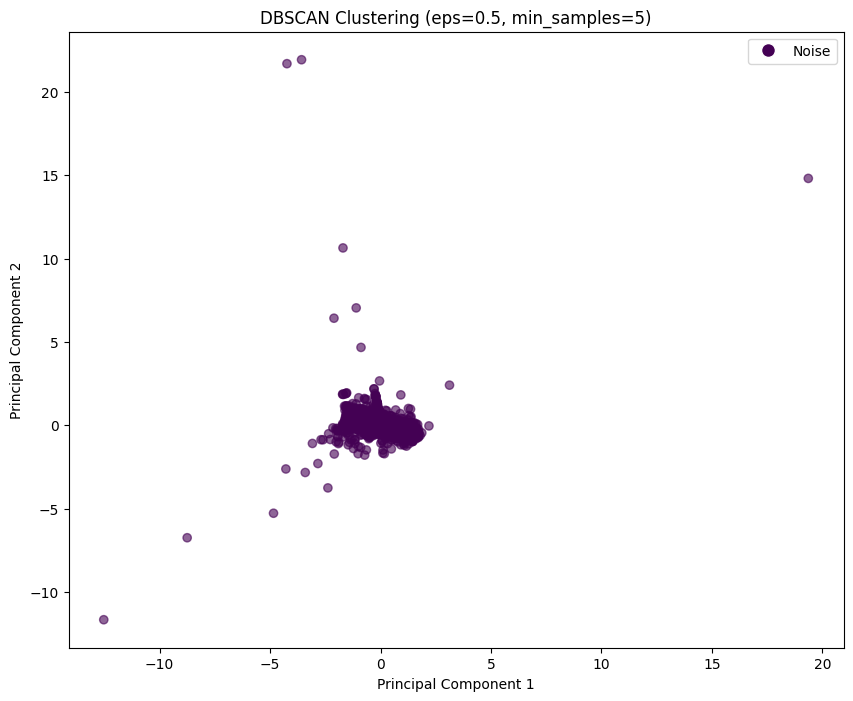

In [24]:
# Mencari epsilon optimal dengan k-distance graph
from sklearn.neighbors import NearestNeighbors

# Ambil sampel jika data terlalu besar
X_sample = X if X.shape[0] < 5000 else X[np.random.choice(X.shape[0], 5000, replace=False)]

# Compute k-distances
k = 5  # jumlah tetangga
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_sample)
distances, indices = neigh.kneighbors(X_sample)
distances = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title('K-distance Graph (k=5)')
plt.xlabel('Data Points (sorted)')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.grid(True)
plt.show()

# Berdasarkan k-distance graph, pilih epsilon yang sesuai
epsilon = 0.5  # Ganti dengan nilai berdasarkan analisis k-distance graph
min_samples = 5  # Minimal points untuk membentuk cluster

# Fit DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters_dbscan = dbscan.fit_predict(X)

# Evaluasi DBSCAN
n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)
print(f"\nEvaluasi DBSCAN (eps={epsilon}, min_samples={min_samples}):")
print(f"Jumlah Cluster: {n_clusters}")
print(f"Jumlah Noise Points: {n_noise} ({n_noise/len(clusters_dbscan)*100:.2f}%)")

if n_clusters > 1:  # Silhouette score hanya valid jika ada lebih dari 1 cluster
    # Hitung silhouette score tanpa noise points
    mask = clusters_dbscan != -1
    if sum(mask) > 1:  # Pastikan ada lebih dari 1 data point setelah menghapus noise
        silhouette_dbscan = silhouette_score(X[mask], clusters_dbscan[mask])
        print(f"Silhouette Score (tanpa noise): {silhouette_dbscan:.4f}")

# Visualisasi hasil DBSCAN pada data yang telah di-PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_dbscan, cmap='viridis', alpha=0.6)
plt.title(f'DBSCAN Clustering (eps={epsilon}, min_samples={min_samples})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Tambahkan legend manual untuk noise points
unique_clusters = set(clusters_dbscan)
if -1 in unique_clusters:
    unique_clusters.remove(-1)
    unique_clusters = list(unique_clusters)
    unique_clusters = [-1] + sorted(unique_clusters)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=scatter.cmap(scatter.norm(c)),
                                  markersize=10, label=f'Cluster {c}' if c != -1 else 'Noise')
                      for c in unique_clusters]
    plt.legend(handles=legend_elements)
plt.show()

HIERARCHICAL CLUSTERING (AgglomerativeClustering)


Evaluasi Agglomerative Clustering (n_clusters=3):
Silhouette Score: 0.1046
Davies-Bouldin Index: 1.7359


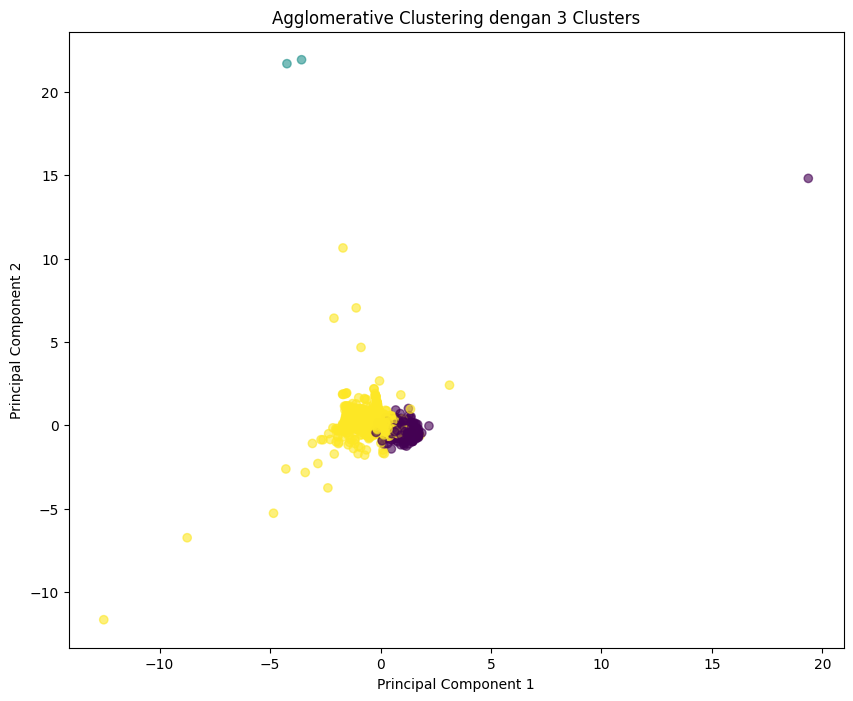

In [25]:
# Fit Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=k_optimal)
clusters_agg = agg_clustering.fit_predict(X)

# Evaluasi Agglomerative Clustering
silhouette_agg = silhouette_score(X, clusters_agg)
davies_bouldin_agg = davies_bouldin_score(X, clusters_agg)
print(f"\nEvaluasi Agglomerative Clustering (n_clusters={k_optimal}):")
print(f"Silhouette Score: {silhouette_agg:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_agg:.4f}")

# Visualisasi hasil Agglomerative Clustering pada data yang telah di-PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_agg, cmap='viridis', alpha=0.6)
plt.title(f'Agglomerative Clustering dengan {k_optimal} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plot dendrogram (untuk dataset kecil)
if X.shape[0] <= 100:  # Hanya tampilkan jika data cukup kecil
    from scipy.cluster.hierarchy import dendrogram, linkage

    linkage_matrix = linkage(X[:100], method='ward')
    plt.figure(figsize=(15, 8))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram (100 sampel pertama)')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

GAUSSIAN MIXTURE MODEL


Evaluasi Gaussian Mixture Model (n_components=3):
Silhouette Score: 0.1179
BIC: 263318951.312971
AIC: -17405387.504499316


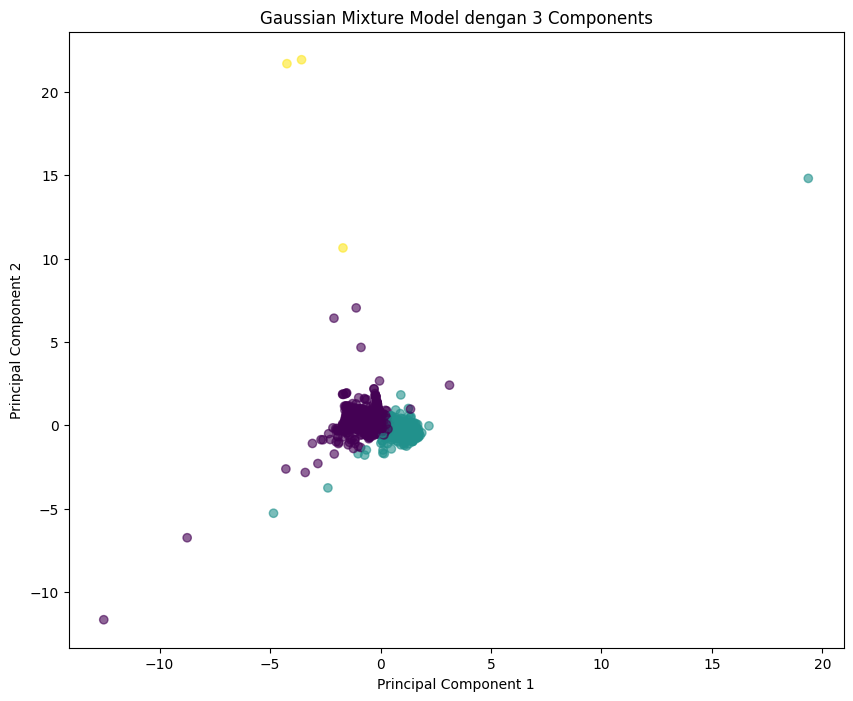

In [26]:
# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=k_optimal, random_state=42)
clusters_gmm = gmm.fit_predict(X)

# Evaluasi GMM
silhouette_gmm = silhouette_score(X, clusters_gmm)
print(f"\nEvaluasi Gaussian Mixture Model (n_components={k_optimal}):")
print(f"Silhouette Score: {silhouette_gmm:.4f}")
print(f"BIC: {gmm.bic(X)}")
print(f"AIC: {gmm.aic(X)}")

# Visualisasi hasil GMM pada data yang telah di-PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_gmm, cmap='viridis', alpha=0.6)
plt.title(f'Gaussian Mixture Model dengan {k_optimal} Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

PERBANDINGAN SEMUA MODEL

In [27]:
# Tambahkan cluster labels ke dataframe asli
df_results = pd.DataFrame({
    'KMeans': clusters_kmeans,
    'DBSCAN': clusters_dbscan,
    'Agglomerative': clusters_agg,
    'GMM': clusters_gmm
})

# Summary hasil clustering
print("\nPerbandingan Hasil Clustering:")
print(f"{'Model':<20} {'Jumlah Cluster':<15} {'Silhouette Score':<20}")
print("-" * 55)

models = {
    'KMeans': {'clusters': len(set(clusters_kmeans)), 'silhouette': silhouette_kmeans},
    'DBSCAN': {'clusters': n_clusters, 'silhouette': silhouette_dbscan if n_clusters > 1 and 'silhouette_dbscan' in locals() else 'N/A'},
    'Agglomerative': {'clusters': len(set(clusters_agg)), 'silhouette': silhouette_agg},
    'GMM': {'clusters': len(set(clusters_gmm)), 'silhouette': silhouette_gmm}
}

for model_name, metrics in models.items():
    print(f"{model_name:<20} {metrics['clusters']:<15} {metrics['silhouette'] if isinstance(metrics['silhouette'], float) else metrics['silhouette']}")



Perbandingan Hasil Clustering:
Model                Jumlah Cluster  Silhouette Score    
-------------------------------------------------------
KMeans               3               0.11788439704342094
DBSCAN               0               N/A
Agglomerative        3               0.1045709495632277
GMM                  3               0.11788439704342094


ANALISIS CLUSTER


Model terbaik berdasarkan Silhouette Score: KMeans (Score: 0.1179)

Rata-rata Fitur Numerik per Cluster:
         Quantity   UnitPrice    CustomerID
Cluster                                    
0        9.385978    3.578640  14382.279297
1        7.617094    2.636803  17030.498047
2        0.333333  187.490005  14629.666992


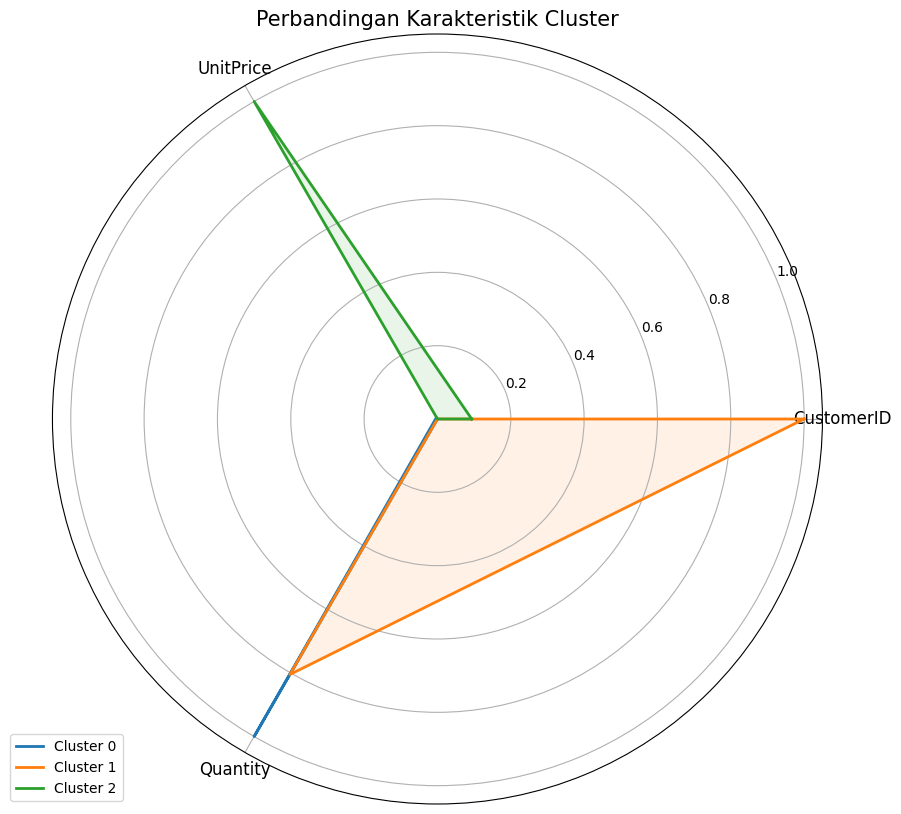

In [28]:
# Pilih model terbaik berdasarkan silhouette score
best_silhouette = -1
best_model = None
best_clusters = None

for model_name, metrics in models.items():
    if isinstance(metrics['silhouette'], float) and metrics['silhouette'] > best_silhouette:
        best_silhouette = metrics['silhouette']
        best_model = model_name
        if model_name == 'KMeans':
            best_clusters = clusters_kmeans
        elif model_name == 'DBSCAN':
            best_clusters = clusters_dbscan
        elif model_name == 'Agglomerative':
            best_clusters = clusters_agg
        elif model_name == 'GMM':
            best_clusters = clusters_gmm

print(f"\nModel terbaik berdasarkan Silhouette Score: {best_model} (Score: {best_silhouette:.4f})")

# Analisis karakteristik cluster dari model terbaik
# Tambahkan cluster labels ke data asli
df_clean['Cluster'] = best_clusters

# Analisis statistik per cluster
cluster_stats = df_clean.groupby('Cluster')[numerical_cols].mean()
print("\nRata-rata Fitur Numerik per Cluster:")
print(cluster_stats)

# Visualisasi radar chart untuk membandingkan cluster (untuk fitur numerik top 5)
# Pilih top 5 fitur yang memiliki standar deviasi terbesar antar cluster
std_per_feature = cluster_stats.std()
top_features = std_per_feature.sort_values(ascending=False).index[:5].tolist()

# Normalisasi data untuk radar chart
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
radar_data = scaler.fit_transform(cluster_stats[top_features])
radar_data = pd.DataFrame(radar_data, index=cluster_stats.index, columns=top_features)

# Plot radar chart
from math import pi
import matplotlib.pyplot as plt

# Jumlah variabel
categories = top_features
N = len(categories)

# Hitung sudut untuk setiap axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot untuk setiap cluster
for i, cluster in enumerate(radar_data.index):
    values = radar_data.loc[cluster].values.tolist()
    values += values[:1]  # Close the loop

    # Plot data
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster}')
    # Fill area
    ax.fill(angles, values, alpha=0.1)

# Set category labels
plt.xticks(angles[:-1], categories, size=12)

# Tambahkan legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Perbandingan Karakteristik Cluster', size=15)
plt.show()